In [1]:
from cgeniepy.ecology import EcoModel
import pandas as pd
from cgeniepy.array import GriddedData
from pathlib import Path
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
from matplotlib import colors
## use Hevetica font
plt.rcParams['font.family'] = 'Helvetica'

model_path = Path("../model")

## list all folders containing "EXP1'
exp3 = [str(x) for x in model_path.iterdir() if x.is_dir() and "EXP3" in x.name]
exp4 = [str(x) for x in model_path.iterdir() if x.is_dir() and "EXP4" in x.name]
exp5 = [str(x) for x in model_path.iterdir() if x.is_dir() and "EXP5" in x.name]

m3 = EcoModel(exp3, gemflag=['biogem', 'ecogem'])
m4 = EcoModel(exp4, gemflag=['biogem', 'ecogem'])
m5 = EcoModel(exp5, gemflag=['biogem', 'ecogem'])

<frozen importlib._bootstrap>:241: RuntimeWarning: scipy._lib.messagestream.MessageStream size changed, may indicate binary incompatibility. Expected 56 from C header, got 64 from PyObject


In [2]:
def ocn_var_change(model, variable, anomaly=True):
    if anomaly:
        var0 = model.get_var(variable).isel(time=0).mean(dim=['model']).data
        var1 = model.get_var(variable).isel(time=[1,2]).mean(dim=['model', 'time']).data
        diff = var1 - var0
        return GriddedData(diff)
    else:
        var1 = model.get_var(variable).isel(time=[1,2]).mean(dim=['model', 'time']).data
        return GriddedData(var1)
    

def temp_effect(variable):

    return ocn_var_change(m4, variable)

def par_effect(variable):
    return ocn_var_change(m5, variable)

def total_effect(variable):
    return ocn_var_change(m3, variable)

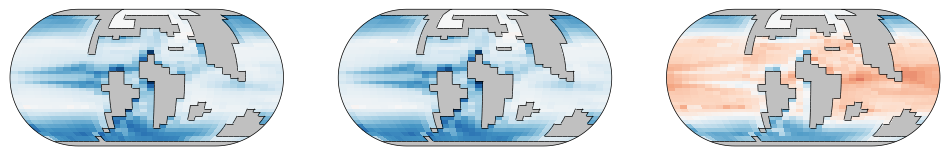

In [6]:
fig, axs = plt.subplots(1,3,figsize=(12, 3), subplot_kw={'projection': ccrs.EckertIV()})


var_to_plot = {
    "eco2D_Uptake_Fluxes_C": ['NPP', 'RdBu_r', r'g C m$^{-2}$ yr$^{-1}$',  200],
}


for i, var in enumerate(var_to_plot.keys()):
    values = var_to_plot[var]
    for j, func in enumerate([total_effect, temp_effect, par_effect]):
        data = func(var)        
        data = data * 80.8 * 12 * 365 * 1E-3 #to g C m-2 yr-1
        data.attrs = {'long_name': values[1], 'units': values}
        data_plotter = data.to_GriddedDataVis()
        data_plotter.aes_dict['pcolormesh_kwargs']['cmap'] = values[1]
        data_plotter.aes_dict['pcolormesh_kwargs']['norm'] = colors.CenteredNorm(halfrange=values[3])

        p = data_plotter.plot(ax=axs[j], outline=True, colorbar=False)

In [7]:
## add colorbar
## colorbar for each row
fig.colorbar(p, ax=axs, orientation='horizontal', label=values[2], fraction=0.046)

In [8]:
## add alphabetic labels for each subplot
for i, ax in enumerate(axs.flat):
    ax.text(0, 1.0, chr(97+i), transform=ax.transAxes, 
            fontsize=12, fontweight='bold', va='top')

axs[0].text(-0.1, 0.5, "NPP", transform=axs[0].transAxes, rotation=90, fontdict={'fontsize': 12, 'fontweight': 'normal'}, va='center')

effects = ['Total change', 'fixed temperature', 'fixed PAR']
for i, ax in enumerate(axs.flat):
    label = effects[i]
    ax.set_title(label, transform=ax.transAxes, fontdict={'fontsize': 12, 'fontweight': 'normal'})

fig.savefig('../output/fig_ecosystem_change.png', dpi=300, bbox_inches='tight')

In [5]:
## functional group number
# all_plankton = m3.get_pft(list(range(1,19)))
# x = all_plankton.array.mean(dim='model')
# (x>1E-2).sum(dim='variable').isel(time=0).plot()